# how to decompose the impulse response of an ARMA model in its modes

To do the task we will assume the user will give as an input the vectors of the coefficients defining an ARMA model. For example, defining below ` numerator = [1, -1] ` and ` denominator = [1, 4, 3] ` will implicitly mean defining the impulse response
$$
H(s) = \frac{s - 1}{s^2 + 4 s + 3}
$$
and thus the ARMA model
$$
\ddot{y} + 4 \dot{y} + 3 y = \dot{u} - u .
$$
The code we want to develop will thus decompose the corresponding impulse response associated to that $H(s)$ into its modes, and plot them separatedly.

In [ ]:
# import the necessary stuff
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt 
import control # see python-control.readthedocs.io
from scipy.integrate import odeint

In [4]:
# define the variables that we need for the task
t = sp.symbols('t', real=True) # 'time'
s = sp.symbols('s')            # 's' for the Laplace domain
x = sp.symbols('x', real=True) # 'state'

A first function we would like to implement first is the ZPP map, https://en.wikipedia.org/wiki/Pole%E2%80%93zero_plot. In this way we get exposed to the ` control.tf `, ` .pole() ` and ` .zero() ` functions: 

In [5]:
# plot the poles and zeros of a transfer function
def plotPoleZeroPlot(numerator, denominator):
    
    transferFunction = control.tf(numerator, denominator)

    # Get the poles and zeros
    poles = transferFunction.pole()
    zeros = transferFunction.zero()

    # Find the re-im of the poles
    a = [x.real for x in poles]
    b = [x.imag for x in poles]

    # Find the re-im of the zeros
    c = [x.real for x in zeros]
    d = [x.imag for x in zeros]

    # Plot them and create a layout
    plt.title("Zeros Poles Plot of the transfer function")
    plt.scatter(a,b, marker="x")
    plt.scatter(c,d)
    plt.grid(True, which='both')
    plt.xlabel("real part")
    plt.ylabel("imaginary part")
    plt.axhline(0)
    plt.axvline(0)
    plt.show()

Then with other plots we can get exposed to even further functions from the ` control ` package:

In [6]:
# Plot the impulse response
def plotImpulseResponse(numerator, denominator):
    
    transferFunction = control.tf(numerator, denominator)
    T, yout = control.impulse_response(transferFunction)
    
    plt.plot(T, yout)
    plt.title("Impulse response of h(s)")
    plt.xlabel("Time")
    plt.ylabel("h(t)")
    plt.show()

In [7]:
# Plot the step response 
def plotStepResponse(numerator, denominator):
    
    transferFunction = control.tf(numerator, denominator)
    T, yout = control.step_response(transferFunction)
    
    plt.plot(T, yout)
    plt.title("Step response of h(s)")
    plt.xlabel("Time")
    plt.ylabel("h(t)")
    plt.show()

To do partial fraction decompositions we ladder ` sympy `. Thus we define an ad-hoc function to move to ` sympy ` from ` control ` objects:

In [13]:
# Convert a control library representation to a sympy one
def controlToSympy(num, den):
    
    # Create a sympy fraction
    numSym = 0
    denSym = 0
    
    for counter, coefficient in enumerate(reversed(num)):
        numSym += coefficient*x**counter
    
    for counter, coefficient in enumerate(reversed(den)):
        denSym += coefficient*x**counter
    
    return numSym/denSym


This means we may use ` sympy.apart ` to do the wished partial fraction decomposition:

In [10]:
# Extract each mode, ignore this
def extractModes(num, den):

    # Get the fraction
    symFraction = controlToSympy(num, den)
    
    # Get the partial fraction decomposition
    partialFracDecomped = apart(symFraction).as_ordered_terms()
    
    # The list of fractions
    listOfFractions = []

    # Decompose the fractions and add it to the list
    for subFractions in partialFracDecomped:
        # Decompose a fraction into numerator and denominator
        numCont, denCont = fraction(subFractions)
        # Extract the coefficients and convert to correct type
        numPolynom = [int(e) for e in Poly(numCont, x).all_coeffs()]
        denPolynom = [int(e) for e in Poly(denCont, x).all_coeffs()]
        listOfFractions.append([numPolynom, denPolynom])

    return listOfFractions


We can finally sum up several functions in one that, laddering on the fact that each partial fraction can be thought as its own impulse response, extracts the individual modes from a given ARMA model:

In [11]:
# Plot all the modes of the transfer function
def plotModes(numerator, denominator):
    
    # Extract the modes of the transfer function
    modes = extractModes(numerator, denominator)
    
    # Plot each mode independently
    for mode in modes:
        num,den = mode
        transfer = control.tf(num,den)
        T, yout = control.impulse_response(transfer)
        plt.plot(T,yout)
    
    # Add some information to the plot
    plt.title("decomposition of the impulse response in its elementary modes")
    plt.xlabel("Time")
    plt.ylabel("h(t)")
    plt.show()


Let's do an example here:

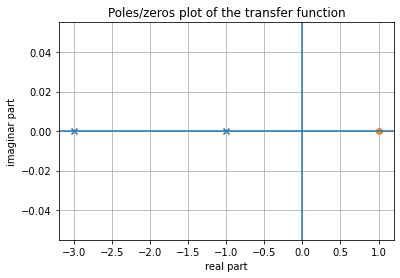

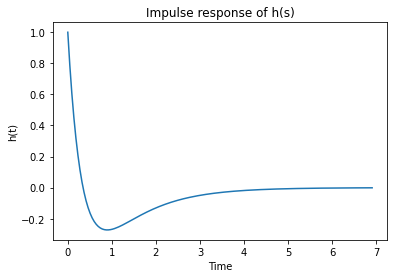

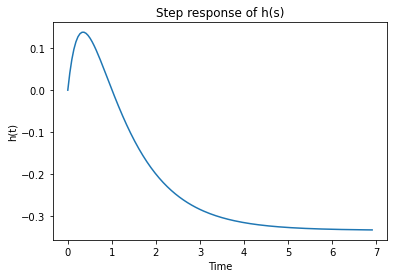

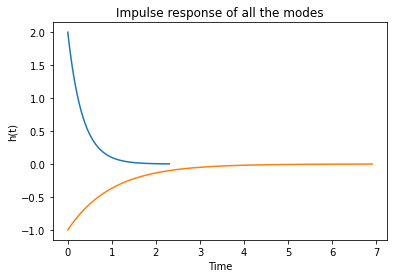

In [14]:
# Define the transfer function
#
# example:
#           s - 1             numerator   = [1, -1]
# H = ----------------- =>    denominator = [1, 4, 3]
#       s^2 + 4 s + 3
#
numerator = [1, -1]
denominator = [1, 4, 3]

# Plot the various things
plotPoleZeroPlot(numerator, denominator)
plotImpulseResponse(numerator, denominator)
plotStepResponse(numerator, denominator)
plotModes(numerator, denominator)